In [284]:
# Multi-dimensional reconstruction

import numpy as np
import matplotlib.pyplot as plt
import pydrr as pd #pd: DRR

## generate the synthetic data
a1=np.zeros([300,20])
[n,m]=a1.shape
a3=np.zeros([300,20])
a4=np.zeros([300,20])

k=-1;
a=0.1;
b=1;
pi=np.pi

ts=np.arange(-0.055,0.055+0.002,0.002)
b1=np.zeros([len(ts)])
b2=np.zeros([len(ts)])
b3=np.zeros([len(ts)])
b4=np.zeros([len(ts)])

for t in ts:
    k=k+1;
    b1[k]=(1-2*(pi*30*t)*(pi*30*t))*np.exp(-(pi*30*t)*(pi*30*t));
    b2[k]=(1-2*(pi*40*t)*(pi*40*t))*np.exp(-(pi*40*t)*(pi*40*t));
    b3[k]=(1-2*(pi*40*t)*(pi*40*t))*np.exp(-(pi*40*t)*(pi*40*t));
    b4[k]=(1-2*(pi*30*t)*(pi*30*t))*np.exp(-(pi*30*t)*(pi*30*t));

t1=np.zeros([m],dtype='int')
t3=np.zeros([m],dtype='int')
t4=np.zeros([m],dtype='int')
for i in range(m):
  t1[i]=np.round(140);
  t3[i]=np.round(-6*i+180);
  t4[i]=np.round(6*i+10);
  a1[t1[i]:t1[i]+k+1,i]=b1; 
  a3[t3[i]:t3[i]+k+1,i]=b1; 
  a4[t4[i]:t4[i]+k+1,i]=b1; 

temp=a1[0:300,:]+a3[0:300,:]+a4[0:300,:];

shot=np.zeros([300,20,20])
for j in range(20):
    a4=np.zeros([300,20]);
    for i in range(m):
    	t4[i]=np.round(6*i+10+3*j); 
    	a4[t4[i]:t4[i]+k+1,i]=b1;
  
    	t1[i]=np.round(140-2*j);
    	a1[t1[i]:t1[i]+k+1,i]=b1;

    shot[:,:,j]=a1[0:300,:]+a3[0:300,:]+a4[0:300,:];

dc=shot




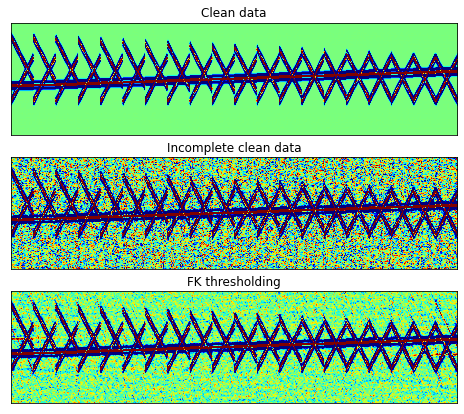

In [285]:
## Denoising only

np.random.seed(202223);
[n1,n2,n3]=dc.shape;
dn=dc+0.1*np.random.randn(n1,n2,n3)

dnfk=fkt(dn,'ps',50);

import scipy
from scipy import io
datas = {"dn":dn,'dnfk':dnfk,'dnfft':fftn(dn),'dnfftthr':pthresh(fftn(dn),'ps',50),'t':np.percentile(np.abs(fftn(dn)).flatten(),50),'test':pthresh(fftn(dn),'s',29.8539)}
scipy.io.savemat("datas_fkthr.mat", datas)

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(dn.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow(dnfk.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('FK thresholding');

In [286]:
## decimate traces
ratio=0.5;
mask=pd.genmask(dn.reshape(n1,n2*n3,order='F'),ratio,'c',201415);
mask=mask.reshape(n1,n2,n3,order='F');
d0=dc*mask;


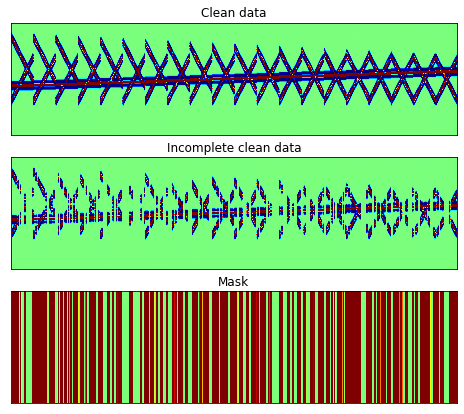

In [287]:
fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow((mask).transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Mask');

plt.show()


In [288]:
def csign(x):
    #sign function for complex value
    return x/(abs(x)+0.00000000001)
    
## define the thresholding function
def pthresh(x,sorh='ps',t=5):
    y=x.copy()
    import numpy as np
    if sorh == 's':
        tmp=(np.abs(x)-t);
        tmp=(tmp+np.abs(tmp))/2;
        if x.dtype=='complex':
            y=csign(x)*tmp;
        else:
            y=np.sign(x)*tmp; 
        ## HERE, very important, took very long to figure out the problem
        ## Cannot use numpy.sign because:
        ## There is more than one definition of sign in common use for complex numbers. The definition used here (in numpy) is equivalent to x/sqrt(x*x) which is different from a common alternative, x/abs(x).
        
    elif sorh == 'h':
        y=x*(np.abs(x)>t);
    elif sorh == 'ps':
        tmp=np.abs(x).flatten();
        t=np.percentile(tmp,100-t);
        thr=t;
        tmp=(np.abs(x)-t);
        tmp=(tmp+np.abs(tmp))/2;
        
        if x.dtype=='complex':
            y=csign(x)*tmp;
        else:
            y=np.sign(x)*tmp; 
            
    elif sort == 'ph':
        tmp=np.abs(x).reshape(1,x.size);
        t=np.percentile(tmp,100-t);
        thr=t;
        y=x*(np.abs(x)>t);
    else:
        print('Invalid argument value.');
    return y

def fkt(D,sorh='ps',thr=5):
    from scipy.fft import fftn,ifftn
    D1=ifftn(pthresh(fftn(D),sorh,thr));
    D1=np.real(D1);
    return D1

def fk_pocs(D,D0,mask,thr,niter):
    D1=D0;
    for ii in range(niter):
        D1=D*mask + (1-mask)*fkt(D1,sorh='ps',thr=thr);
        
    return D1

def snr(g,f):
    '''
    SNR: calculate the signal-to-noise ratio (SNR)
    '''
    import numpy as np
    psnr = 20.*np.log10(np.linalg.norm(g[:])/np.linalg.norm(g[:]-f[:]));
    return psnr

d_fk=fk_pocs(d0,np.zeros(d0.shape),mask,2,100);

## compare SNR
print('SNR of d0 is %g'%snr(dc.flatten(),d0.flatten()));
print('SNR of d_fk is %g'%snr(dc.flatten(),d_fk.flatten()));

import scipy
from scipy import io
datas = {"d0":d0,"dc":dc,'dfk':d_fk,"mask":mask}
scipy.io.savemat("datas3d.mat", datas)

SNR of d0 is 2.92968
SNR of d_fk is 15.0206


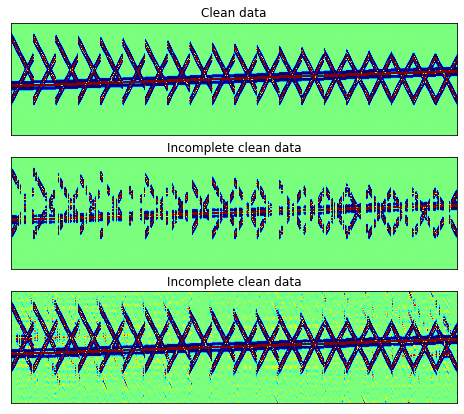

In [289]:

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');
ax=fig.add_subplot(3, 1, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');
ax=fig.add_subplot(3, 1, 3)
plt.imshow(d_fk.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete clean data');
plt.show()


0.24472818719725775
0.17176208519313502


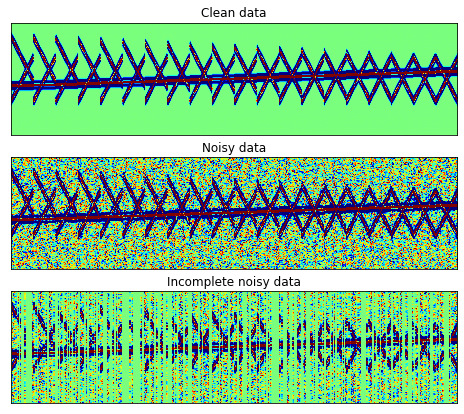

In [290]:


## add noise
[n1,n2,n3]=dc.shape
np.random.seed(201415)
n=0.1*np.random.randn(n1,n2,n3);
dn=dc+n;
print(np.std(dn))

## decimate traces
ratio=0.5;
mask=pd.genmask(dn.reshape(n1,n2*n3,order='F'),ratio,'c',201415);
mask=mask.reshape(n1,n2,n3,order='F');
d0=dn*mask;
print(np.std(d0))

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(dn.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');

plt.show()

In [291]:
## Sparse reconstruction using Fourier transform
from scipy.fft import fftn,ifftn
import scipy.fft

dc_fftn=fftn(dc);
dn_fftn=fftn(dn);
d0_fftn=fftn(d0);



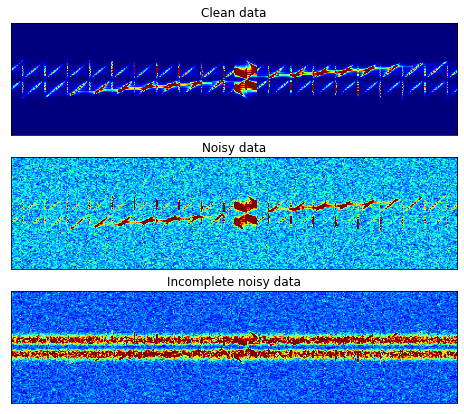

In [292]:
dc_fftn_abs=np.abs(scipy.fft.fftshift(dc_fftn))
dn_fftn_abs=np.abs(scipy.fft.fftshift(dn_fftn))
d0_fftn_abs=np.abs(scipy.fft.fftshift(d0_fftn))

fig = plt.figure(figsize=(8, 7))
ax=fig.add_subplot(3, 1, 1)
plt.imshow(dc_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');

ax=fig.add_subplot(3, 1, 2)
plt.imshow(dn_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Noisy data');

ax=fig.add_subplot(3, 1, 3)
plt.imshow(d0_fftn_abs.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(0, 100),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');

plt.show()

In [2]:
## Recon
flow=0;fhigh=125;dt=0.004;N=3;NN=3;Niter=10;mode=1;a=np.linspace(1,0,10);verb=1;eps=0.00000000001;
d1=pd.drr3drecon(d0,mask,flow,fhigh,dt,N,100,Niter,eps,mode,a,verb);
d2=pd.drr3drecon(d0,mask,flow,fhigh,dt,N,NN,Niter,eps,mode,a,verb);
noi1=dc-d1;
noi2=dc-d2;



flow= 0 fhigh= 125 dt= 0.004 N= 3 K= 100 Niter= 10 eps= 1e-11 mode= 1 verb= 1
mask.shape (20, 20)
F 5 is done!
F 10 is done!
F 15 is done!
F 20 is done!
F 25 is done!
F 30 is done!
F 35 is done!
F 40 is done!
F 45 is done!
F 50 is done!
F 55 is done!
F 60 is done!
F 65 is done!
F 70 is done!
F 75 is done!
F 80 is done!
F 85 is done!
F 90 is done!
F 95 is done!
F 100 is done!
F 105 is done!
F 110 is done!
F 115 is done!
F 120 is done!
F 125 is done!
F 130 is done!
F 135 is done!
F 140 is done!
F 145 is done!
F 150 is done!
F 155 is done!
F 160 is done!
F 165 is done!
F 170 is done!
F 175 is done!
F 180 is done!
F 185 is done!
F 190 is done!
F 195 is done!
F 200 is done!
F 205 is done!
F 210 is done!
F 215 is done!
F 220 is done!
F 225 is done!
F 230 is done!
F 235 is done!
F 240 is done!
F 245 is done!
F 250 is done!
F 255 is done!
flow= 0 fhigh= 125 dt= 0.004 N= 3 K= 3 Niter= 10 eps= 1e-11 mode= 1 verb= 1
mask.shape (20, 20)
F 5 is done!
F 10 is done!
F 15 is done!
F 20 is done!
F 25 i

In [42]:
## compare SNR
print('SNR of RR is %g'%pd.snr(dc,d1,2));
print('SNR of DRR is %g'%pd.snr(dc,d2,2));


print('SNR of RR is %g'%snr(dc.flatten(),d1.flatten()));
print('SNR of DRR is %g'%snr(dc.flatten(),d2.flatten()));

SNR of RR is 16.6763
SNR of DRR is 18.8706
SNR of RR is 16.6763
SNR of DRR is 18.8706


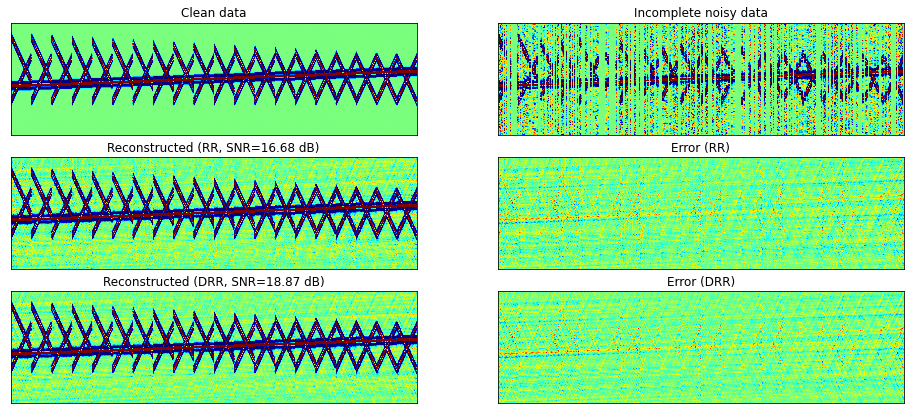

In [4]:

## plotting
fig = plt.figure(figsize=(16, 7))
ax=fig.add_subplot(3, 2, 1)
plt.imshow(dc.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Clean data');
ax=fig.add_subplot(3, 2, 2)
plt.imshow(d0.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Incomplete noisy data');
ax=fig.add_subplot(3, 2, 3)
plt.imshow(d1.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Reconstructed (RR, SNR=%.4g dB)'%pd.snr(dc,d1,2));
ax=fig.add_subplot(3, 2, 4)
plt.imshow(noi1.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Error (RR)');
ax=fig.add_subplot(3, 2, 5)
plt.imshow(d2.reshape(n1,n2*n3,order='F'),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Reconstructed (DRR, SNR=%.4g dB)'%pd.snr(dc,d2,2));
ax=fig.add_subplot(3, 2, 6)
plt.imshow(noi2.transpose(0,2,1).reshape(n1,n2*n3),cmap='jet',clim=(-0.1, 0.1),aspect='auto');ax.set_xticks([]);ax.set_yticks([]);
plt.title('Error (DRR)');
plt.savefig('test_pydrr_drr3drecon.png',format='png',dpi=300);
plt.show()


In [103]:
np.abs(1+1j)

1.4142135623730951